In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

 # Environ class:  
 This sets up the environment being imaged, and includes the number and positioning   
 of mics, the speed of sound, sampling rate or microphones ADC and the least count of the grid used.  
  
Answer to Question-  
The images vertical dimension covers all the microphones and the horizontal depth is given by the formula x = sqrt((D+3y^2/D)^2-4y^2), where y is the distance from the source to the farthest mic, and D is the maximum distance sound has travelled befoe the mics stopped recording. This is because the sound travelling from the source to the upper right hand corner of the image to the lowermost microphone must reach the microphone before it stops recording, so as to image an object if it is present there.

In [141]:

class Environ:
  def __init__(self,Nmics,Nsamp,pitch,dist_per_samp, C, grid_lc):
    # Main system parameters: number of mics, number of samples in time
    # number of samples in time was included in environ class, as the furthest object that can be detected depends on it
    self.Nmics = Nmics
    self.Nsamp = Nsamp
    #Least Count of image grid
    self.grid_lc=grid_lc
    # proxy for sampling rate
    self.dist_per_samp = dist_per_samp
    self.src = (0,0)
    # Spacing between microphones
    self.pitch = pitch
    # Speed of sound in the medium
    self.C = C
    # CODE Locations of microphones (x coordinates)
    self.mics = []
    self.Dmax=(Nsamp-1)*dist_per_samp
    if self.Nmics%2==0:
      for i in range(self.Nmics//2):
          self.mics.append(-(self.Nmics//2)*pitch+i*pitch+pitch/2) # origin excluded
      for i in range(self.Nmics//2):
          self.mics.append(i*pitch+pitch/2) # origin excluded
    else:
      for i in range(-self.Nmics//2,self.Nmics//2+1):
        self.mics.append(i*pitch) # origin included
    self.mics=np.array(self.mics)

    #  Calculating depth of image
  def depth(self):
    y=(self.Nmics//2)*self.pitch # Nsamp has to be // by 2 first
    if self.Dmax<3*y:
      print("Time of sampling is too less")
      return -1
    depth=np.sqrt((self.Dmax+3*y**2/self.Dmax)**2/4-4*y**2)
    return depth

  def timeindex(self,pt):
    # Will return the number of samples taken before a wave from the source reflects off a point hits a mic
    # Returns array for each mic
    return (np.sqrt((self.mics-pt[0])**2+pt[1]**2)//self.dist_per_samp).astype('int')

  def reconstruct_img(self,Sig):
    im=[]
    depth=self.depth()
    pt=[self.mics[0],0]
    while pt[0]<=self.mics[-1]:
      im.append([])
      while pt[1]<=depth:
        im[-1].append(np.sum(Sig[np.arange(self.Nmics), self.timeindex(pt)]))
        pt[1]+=self.grid_lc
      pt[1]=0
      pt[0]+=self.grid_lc
    return np.array(im)



# testenv class:
This contains all the data and functions needed to set up a set of test signals, given an Environ object in which imaging is done.
  
Answer to question-  
The sinc pulses width can be changed by multiplying the argument of the function by a dilating factor, SincP.

In [135]:
class testenv:
  def __init__(self,environ,obstacle,SincP):
    # Define the environment for the testing
    self.environ = environ
    # Location of point obstacle
    self.obstacle = obstacle
    self.SincP=SincP # source waveform parameter

  def wsrc(self,t):
    return np.sinc(self.SincP*t)

    # Distance from src to a mic after reflecting from pt
  def dist(self):
    pt=self.obstacle
    src=self.environ.src
    mic=self.environ.mics
    d2 = np.sqrt((pt[0])**2+(pt[1]-mic)**2)
    return d2

    # Function returns the microphone signal recorded by all microphones at time "t"
  def signal(self,t):
    Nmics=self.environ.Nmics
    C=self.environ.C
    return self.wsrc(t*np.ones((Nmics,))-self.dist()/C)

    # Function returns the full signal recorded by all microphones
  def signalarray(self):
    dsamp=self.environ.dist_per_samp
    C=self.environ.C
    Nsamp=self.environ.Nsamp
    plt.plot()
    return np.transpose(np.vstack([self.signal(i*dsamp/C) for i in range(Nsamp)]))

  def plotsignals(self):
    s=self.signalarray()
    for i in range(s.shape[0]):
      plt.plot(np.arange(s.shape[1]),s[i,:]+i)

# Reconstruction from signal file:
The environment is created, then the signal is loaded into a numpy array and the image is reconstructed, and displayed as a heatmap.  
Obstacles in rx3 is around-  
(42,32),(63,15), (80,55) in the image, this corresponds to  
(4,0),(6.3,-1.5),(8,2.5)  
Obstacles in rx2 is around-  
(32,42),(63,15) in the image, this corresponds to  
(3,1),(6.3,-1.5)


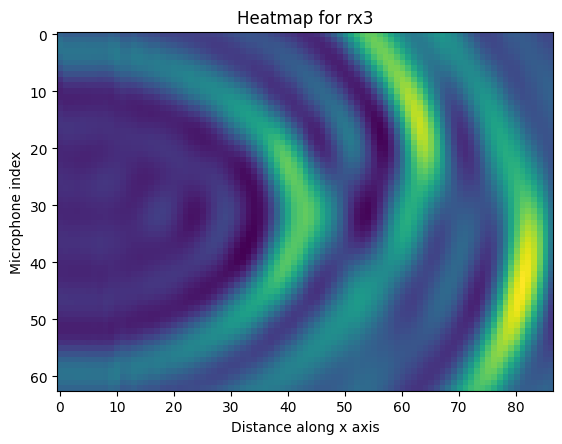

In [142]:
# Reconstructing image from the given text files

Env=Environ(Nmics=64,Nsamp=200,pitch=0.1,dist_per_samp=0.1, C=0.5, grid_lc=0.1)
Sig=np.loadtxt("rx2.txt")
Reconstructedimg=Env.reconstruct_img(Sig)
plt.imshow(Reconstructedimg)
plt.title("Heatmap for rx2")
plt.ylabel("Microphone index")
plt.xlabel("Distance along x axis")
plt.savefig("Imrx2.png")

Sig=np.loadtxt("rx3.txt")
Reconstructedimg=Env.reconstruct_img(Sig)
plt.title("Heatmap for rx3")
plt.imshow(Reconstructedimg)
plt.ylabel("Microphone index")
plt.xlabel("Distance along x axis")
plt.savefig("Imrx3.png")


Time of sampling is too less


<ipython-input-145-4c50f69e65c8>:8: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(Reconstructedimg)


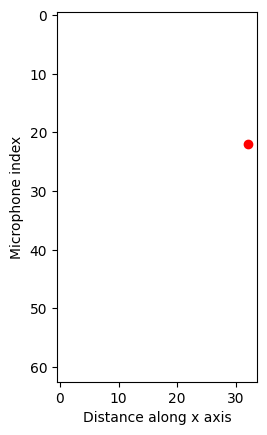

In [145]:
# Reconstructing image from self-made test signals

Env=Environ(Nmics=64,Nsamp=20,pitch=0.1,dist_per_samp=0.1, C=1, grid_lc=0.1) #Nmics=8,Nsamp=20,pitch=0.1,dist_per_samp=0.1, C=0.5, grid_lc=0.1)
Testcase=testenv(environ=Env,obstacle=(3,-1),SincP=5)
Sig=Testcase.signalarray()
#Testcase.plotsignals()
Reconstructedimg=Env.reconstruct_img(Sig)
plt.imshow(Reconstructedimg)
plt.ylabel("Microphone index")
plt.xlabel("Distance along x axis")
plt.plot(32,22, color='red', marker='o')
plt.savefig("rx1.png")

Answer to Questions-
1. The image is at roughly (30,22) as grid_lc*(30,22) is 3,2.2 and as the middle of the y axis is roughly 3.2 (including some edge), relative to the source, the image is (3,-1).
2. The set of x and y coordinates that allow for the image to be reconstructed form a shape formed from 2 ellipse parts. One with foci at the source and the uppermost microphone, another with foci at source and lowermost microphone. The focal sum with be the number of samples * the distance per sample, "D". Hence,  
x_max= semi Latus rectum of that ellipse = D/2 - Nmics^2*pitch^2/8D = 9.974 m.    
y_max= D/2 - Nmics/*pitch/4 = 8.4 m.  
3. The argument of the Sinc function which is the wave, is proportional to SincP/C, hence, a smaller C will reduce the width of the Sinc wave, causing a sharper image. Intutitvely, this means that we are increasing the spatial frequency, but with the same temporal frequency. This is why microscopes often image samples through an oil. Increasing the refractive index increases its resolving power.